## A demo using Hydrogen Hamiltonian with GPT-QE.

In [ ]:
import torch
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [ ]:
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, do_generate_molecule
from gqe.common.initializer import HFStateInitializer
from gqe.util import get_device
from gqe.mingpt.callback import DefaultCallback, PretrainMonitor, PrintMonitor, FileMonitor

# molecule = generate_molecule("Li", "H", 1.596, "sto-3g", bravyi_kitaev=False)
bond_length = 3.0
geometry = f"H 0.0 0.0 0.0\n" + f"Be 0.0 0.0 {bond_length}\n" + f"H 0.0 0.0 {2 * bond_length}\n"
molecule = do_generate_molecule(geometry, "sto-3g", bravyi_kitaev=False)
nqubit = 12

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=False)

# prepare operator_pool
uccsd = UCCSD(nqubit, molecule)
paulis = uccsd.paulis
paulis.append(PauliObservable("IIIIIIIIII"))
print('paulis', paulis)
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=4)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool,
                  [1 / 320, -1 / 320, 1 / 160, -1 / 160, 1 / 80, -1 / 80, 1 / 40, -1 / 40, 0.05, -0.05, 0.1, -0.1, 0.2,
                   -0.2])


## FCI energy by diagonalization

In [ ]:
from qwrapper.hamiltonian import compute_ground_state

#print(compute_ground_state(hamiltonian))

In [ ]:
print("hf state:", hamiltonian.exact_value(initializer.init_circuit(12, [], "qulacs")))

## Setup for GPT

In [ ]:
# create a GPT instance
from gqe.mingpt.model import GPT


def get_gpt(n_gates, total_n_gates):
    model_config = GPT.get_default_config()
    model_config.model_type = 'gpt2'
    model_config.vocab_size = cost.vocab_size()
    model_config.n_gates = n_gates  # The number of gates for each circuit
    model_config.block_size = total_n_gates
    model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
    model_config.embd_pdrop = 0
    model_config.resid_pdrop = 0
    model_config.attn_pdrop = 0
    model_config.std = 0.02
    model_config.energy_offset = 14
    model_config.embd_pdrop = 0
    model_config.resid_pdrop = 0
    model_config.attn_pdrop = 0
    return GPT(model_config, cost)


from gqe.mingpt.trainer import Trainer


def get_trainer(model, max_iters, n_samples=50):
    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
    train_config.max_iters = max_iters
    train_config.num_workers = 10
    train_config.n_samples = n_samples
    trainer = Trainer(train_config, model)
    return trainer



In [ ]:
from torch.utils.data import DataLoader
from gqe.mingpt.data import EnergyDataset
import os

total_ngates = 100


def get_n_gates(data_file):
    items = data_file.split('_')
    return int(items[2])


def to_map(data_files):
    m = {}
    for data_file in data_files:
        n_gate = get_n_gates(data_file)
        if n_gate not in m:
            m[n_gate] = []
        m[n_gate].append(data_file)
    return m


def pretrain(model, data_files, n_gates, total_ngates, batch_size=50, max_iters=10):
    current_file = f'../saved_models/gptqe_pretrain_beh2_{n_gates}_of_{total_ngates}'
    if os.path.exists(current_file):
        return current_file
    if len(data_files) == 0:
        return
    for _, d_files in to_map(data_files).items():
        loader = DataLoader(EnergyDataset(d_files), batch_size=batch_size, shuffle=True)
        callback_generator = DefaultCallback(model, monitors=[PretrainMonitor()], del_temperature=0)
        trainer = get_trainer(model, max_iters=max_iters, n_samples=100)
        trainer.set_callback('on_batch_end', callback_generator.generate())
        trainer.pretrain(loader)
    torch.save(model.state_dict(), current_file)
    return current_file


def train(data_files, n_gates, total_ngates, current_file=None, max_iters=200,
          seeds=[31, 37, 43, 47, 53], temperatures=[10, 30], del_temperature=1):
    for seed in seeds:
        model = get_gpt(n_gates, total_ngates)
        if current_file is not None:
            model.load_state_dict(torch.load(current_file))
        for temperature in temperatures:
            set_seed(seed)
            file_name = f"../output/trajectory_beh2_{n_gates}_{temperature}_{seed}.json"
            model_name = f'../saved_models/gptqe_train_beh2_{n_gates}_of_{total_ngates}_{temperature}_{seed}'
            if os.path.exists(file_name):
                data_files.append(file_name)
                model.load_state_dict(torch.load(model_name))
                print("loaded:" + model_name)
                continue
            file_monitor = FileMonitor()
            model.temperature = temperature
            trainer = get_trainer(model, max_iters=200, n_samples=50)
            trainer.set_callback('on_batch_end', DefaultCallback(model, monitors=[PrintMonitor(), file_monitor],
                                                                 del_temperature=del_temperature).generate())
            trainer.run()
            torch.save(model.state_dict(), model_name)
            file_monitor.save(file_name)
            data_files.append(file_name)
    # Use model with final seed and temperature is used as the reference
    return model

In [ ]:
total_ngates = 40

data_files = [f'../output/trajectory_beh2_4_31.json',
              f'../output/trajectory_beh2_4_37.json',
              f'../output/trajectory_beh2_4_43.json',
              f'../output/trajectory_beh2_4_47.json',
              f'../output/trajectory_beh2_4_53.json'
              ]
n_gates = 8
model = get_gpt(n_gates, total_ngates)
first = True
while n_gates <= total_ngates:
    if first:
        n_iteration = 10
        first = False
    else:
        n_iteration = 3
    current_file = pretrain(model, data_files, n_gates, total_ngates, max_iters=n_iteration, batch_size=200)
    temperatures = [10, 30]
    if n_gates >= 20:
        temperatures = [30, 50, 100]
    model = train(data_files, n_gates, total_ngates, current_file, temperatures=temperatures, del_temperature=1)
    n_gates += 4

KeyboardInterrupt: 

tensor([-15.2814], device='mps:0')
[935, 931, 1072, 686, 931, 686, 212, 1032, 212, 728, 506, 728, 728, 506, 686, 264, 686, 631, 728, 754]


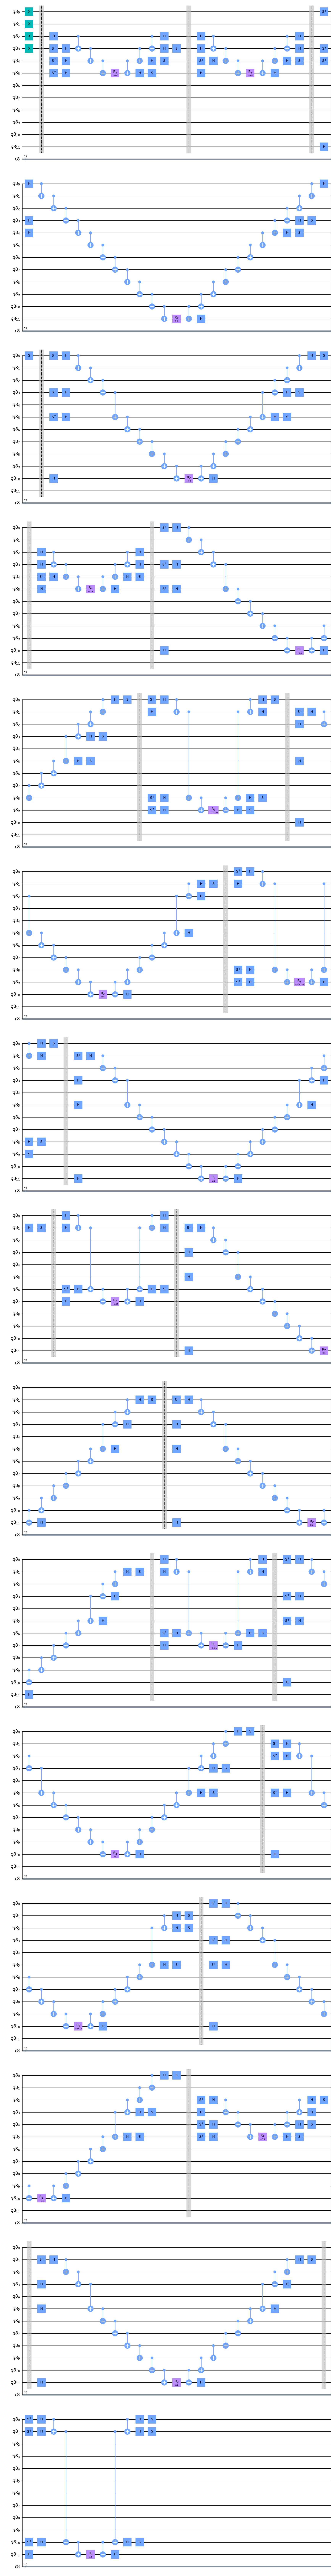

In [176]:
from gqe.util import to_pqc, to_time_evolutions
from gqe.vqa.initializer import InitializerDelegate
from qwrapper.optimizer import AdamOptimizer
from qml.core.vqe import VQE
from qml.core.pqc import TimeEvolutionPQC
from qml.core.function import Energy

model_file = f'../saved_models/gptqe_train_beh2_{20}_of_{40}_{100}_{31}'
model.load_state_dict(torch.load(model_file))
model.temperature = 100
indices = model.generate(torch.zeros(1, 1, dtype=torch.int, device=get_device()), 20)[0]
cost.sequence.tool = "qulacs"
print(cost.energy(indices))
indices = indices[0].cpu().numpy().tolist()
print(indices)
cost.sequence.tool = "qiskit"
cost.sequence.get_circuit(indices).qc.draw(output="mpl", plot_barriers=True)

# model = get_gpt(40, 40).to(get_device())
# for indices in model.generate(torch.zeros(5, 1, dtype=torch.int, device=get_device()), 40)[0]:
#     evolutions = to_time_evolutions(cost.sequence, indices.cpu().numpy().tolist())
#     pqc = TimeEvolutionPQC(cost.sequence.observable.nqubit)
#     for evolution in evolutions:
#         pqc.add_time_evolution(evolution.pauli, evolution.t)
#     initializer = InitializerDelegate(HFStateInitializer(n_electrons=4), nqubit, "qulacs")
#     optimizer = AdamOptimizer(maxiter=3000)
#
#     energy = Energy(hamiltonian, nqubit, pqc)
#     vqe = VQE(energy, initializer, optimizer)
#     prev = vqe.value()
#     vqe.exec()
#
#     print(f"{prev} -> {vqe.value()}")